# Enrichment Analysis using R
____
### Gregory Farage, Śaunak Sen *et al.*
    gfarage@uthsc.edu / sen@uthsc.edu
    Division of Biostatistics
    Department of Preventive Medicine
    University of Tennessee Health Science Center
    Memphis, TN

This notebook carries out encrichment analysis.

## Background

For decades, statins have been effective and widely popular cholesterol-lowering agents with substantial benefits for preventing and treating cardiovascular disease.
However, some patients can not tolerate statins. Statin intolerance is usually associated with muscle pain as side effects, also known as statin-associated muscle symptoms (SAMS). 

**SAMS are particularly difficult to treat:**
* no validated biomarkers or tests to confirm patient self-reports of SAMS
* some self-reported patients have non-specific muscle pain not attributable to statin therapy


## Project Summary

This project seeks to identify biomarkers and pathway's related to susceptibility to SAMS based on metabolomic and lipidomic studies.   

**Comparisons of metabolomic/lipidomic profiling are made for:**
* CS-baseline group vs CS group (paired samples)
* CN group vs CS group (unpaired samples)

**Group’s acronym definition:**
* CS-baseline group: Patients with documented SAMS off statin    

* CS group: Patients with documented SAMS following rechallenge with statin (Rechallenge) for up to 4 weeks or until symptomatic.     
       
* CN group: Controls patients who have no history of SAMS and who are currently treated with statin.

## Libraries

In [1]:
using Pkg 

In [2]:
Pkg.activate("../..")

  Activating project at `~/git/gregfa/metabolomics/mlm-metabolomics-supplement/SAMSstudy`


In [3]:
using CSV, DataFrames, DataFramesMeta, Missings, CategoricalArrays
using StatsBase, Statistics, MatrixLM
using Random, Distributions, StatsModels#, MultivariateStats
using LinearAlgebra, Latexify
using FreqTables, Plots, StatsPlots, Images, FileIO
using Plots.PlotMeasures

In [4]:
# To use RCall for the first time, one needs to 
# the location of the R home directory.
firstTimeRCall = false
if firstTimeRCall
    using Pkg
    io = IOBuffer()
    versioninfo(io)
    if occursin("Windows", String(take!(io)))
        ENV["R_HOME"] = "C:/PROGRA~1/R/R-44~1.0" # from R.home() in R
    else 
        ENV["R_HOME"] = "/usr/lib/R"

    end
    Pkg.build("RCall")
end         

## External functions 

In [5]:
include(joinpath(@__DIR__, "..","..","src","mLinearModel.jl" ));
include(joinpath(@__DIR__,"..","..", "src","myPlots.jl" ));

## Load data

In [6]:
# Load look up table for lipids
LipidsXref = realpath((@__DIR__)*"/../../data/data_processed/inl2b_Lipids_Xref.csv")
dfLipidsXref = DataFrame(CSV.File(LipidsXref));

# Load data set
fileLipids = realpath((@__DIR__)*"/../../data/data_processed/inl2b_Lipids.csv")
dfLipids = DataFrame(CSV.File(fileLipids));

### Filter cases

Select only CN (control - no SAMS history) and CS (cases) patients on statin.

In [7]:
# true => unpaired
# false => paired (rechallenge)
isunpairFlag = true;
dfInd, dfMeta = getCases_new(dfLipids, isunpaired = isunpairFlag);
slctFishOil = true

# Check to filter none fish oil users 
hasFishOil = true;

### Standardize

In [8]:
# standardize lipids mass-to-charge ratio
funStandardize!(dfMeta, isunpaired = isunpairFlag);

## Individual characteristics

Two-way contingency table considering `Group` and `FishOil` variables: 


In [9]:
fullTable = freqtable(dfInd[:, [:FishOil, :Group]], :FishOil, :Group)
matFullfreq = collect(fullTable[:,:]);
matFullfreq = vcat(matFullfreq, sum(matFullfreq, dims= 1))
matFullfreq = hcat(matFullfreq, sum(matFullfreq, dims= 2))
dfFreqFull = DataFrame(matFullfreq, :auto)
rename!(dfFreqFull, Symbol.(vcat(names(fullTable,2), "Total")))
insertcols!(dfFreqFull, 1, :_ => vcat("Fish Oil: ".*(names(fullTable,1)), Symbol("Total")))

Row,_,CN,CS,Total
,Any,Int64,Int64,Int64
1,Fish Oil: no,39,26,65
2,Fish Oil: yes,15,18,33
3,Total,54,44,98


## Lipid characteristics

Each lipid ID corresponds to the nomenclature of a molecule that has been profiled in our lipidomic: 


In [10]:
dfLipidsXref[sample(1:size(dfLipidsXref)[1],3, replace=false, ordered=true), :]

Row,lipID,OriginalNames
,String15,String
1,posLip178,1_Plasmenyl-PE(P-16:0/18:1)+H | 1_Plasmenyl-PE(P-18:1/16:0)+H | 1_Plasmenyl-PE(P-18:0/16:1)+H | 3_Plasmanyl-PE(34:2)+H
2,posLip430,2_TG(16:0_18:0_22:0)+NH4 | 2_TG(16:0_20:0_20:0)+NH4 | 2_TG(16:0_16:0_24:0)+NH4 | 2_TG(18:0_18:0_20:0)+NH4 | 1_TG(16:0_18:0_22:0)+NH4 | 1_TG(18:0_18:0_20:0)+NH4 | 1_TG(14:0_18:0_24:0)+NH4 | 1_TG(16:0_20:0_20:0)+NH4 | 1_TG(14:0_20:0_22:0)+NH4 | 1_TG(16:0_16:0_24:0)+NH4 | 1_TG(14:0_16:0_26:0)+NH4
3,posLip1581,4_TG(18:0_18:0_22:5)+NH4 | 4_TG(18:0_20:0_20:5)+NH4 | 4_TG(18:0_20:1_20:4)+NH4 | 4_TG(18:0_20:2_20:3)+NH4 | 4_TG(18:0_18:1_22:4)+NH4 | 4_TG(18:1_20:0_20:4)+NH4 | 4_TG(18:1_20:2_20:2)+NH4 | 4_TG(18:2_18:2_22:1)+NH4 | 4_TG(18:1_18:2_22:2)+NH4 | 4_TG(18:0_18:2_22:3)+NH4 | 4_TG(18:2_20:0_20:3)+NH4 | 4_TG(18:2_20:1_20:2)+NH4 | 4_TG(18:2_18:3_22:0)+NH4 | 4_TG(18:0_18:3_22:2)+NH4 | 4_TG(18:3_20:0_20:2)+NH4 | 4_TG(18:1_18:4_22:0)+NH4 | 4_TG(18:0_18:4_22:1)+NH4 | 4_TG(18:4_20:0_20:1)+NH4 | 4_TG(17:1_18:4_23:0)+NH4 | 4_TG(17:1_19:0_22:4)+NH4 | 4_TG(17:1_20:4_21:0)+NH4 | 4_TG(16:0_18:4_24:1)+NH4 | 4_TG(16:1_18:4_24:0)+NH4 | 4_TG(16:0_20:5_22:0)+NH4 | 4_TG(16:0_20:4_22:1)+NH4 | 4_TG(16:0_20:3_22:2)+NH4 | 4_TG(16:0_20:2_22:3)+NH4 | 4_TG(16:0_20:1_22:4)+NH4 | 4_TG(16:0_20:0_22:5)+NH4 | 4_TG(16:1_20:4_22:0)+NH4 | 4_TG(16:1_20:2_22:2)+NH4 | 4_TG(16:1_20:0_22:4)+NH4 | 4_TG(15:1_18:4_25:0)+NH4 | 4_TG(15:1_20:4_23:0)+NH4 | 4_TG(15:1_21:0_22:4)+NH4 | 4_TG(14:1_18:4_26:0)+NH4 | 4_TG(14:0_20:5_24:0)+NH4 | 4_TG(14:0_20:4_24:1)+NH4 | 4_TG(14:0_22:0_22:5)+NH4 | 4_TG(14:0_22:1_22:4)+NH4 | 4_TG(14:0_22:2_22:3)+NH4 | 4_TG(14:1_20:4_24:0)+NH4 | 4_TG(14:1_22:0_22:4)+NH4 | 4_TG(14:1_22:2_22:2)+NH4 | 4_TG(12:0_20:5_26:0)+NH4 | 4_TG(12:0_22:5_24:0)+NH4 | 4_TG(12:0_22:4_24:1)+NH4 | 4_TG(10:0_22:5_26:0)+NH4 | 4_TG(19:0_19:0_20:5)+NH4 | 4_TG(18:1_18:1_22:3)+NH4 | 4_TG(18:1_20:1_20:3)+NH4 | 4_TG(18:1_18:3_22:1)+NH4 | 4_TG(18:3_20:1_20:1)+NH4 | 4_TG(17:0_19:0_22:5)+NH4 | 4_TG(17:0_20:5_21:0)+NH4 | 4_TG(17:2_17:2_24:1)+NH4 | 4_TG(17:2_18:3_23:0)+NH4 | 4_TG(17:2_19:0_22:3)+NH4 | 4_TG(17:2_20:3_21:0)+NH4 | 4_TG(16:1_18:3_24:1)+NH4 | 4_TG(16:1_20:3_22:1)+NH4 | 4_TG(16:1_20:1_22:3)+NH4 | 4_TG(15:0_20:5_23:0)+NH4 | 4_TG(15:0_21:0_22:5)+NH4 | 4_TG(14:1_20:3_24:1)+NH4 | 4_TG(14:1_22:1_22:3)+NH4 | 4_TG(13:0_20:5_25:0)+NH4 | 4_TG(13:0_22:5_23:0)+NH4_1


Frequency table of the present lipids main class according to the Grammar of Succinct Lipid Nomenclature (Goslin): 

In [11]:
# Get Zmat 
dfZrawAll =  DataFrame(CSV.File("../../data/data_processed/ZmatRawAll.csv"))

classLipids = freqtable(dfZrawAll.Class)
DataFrame(Class = names(classLipids, 1), Count = collect(classLipids[:]))


Row,Class,Count
,String,Int64
1,Ceramide 1-phosphates [SP0205],11
2,Ceramide phosphocholines (sphingomyelins) [SP0301],158
3,Ceramides [SP02],93
4,Cholesterol and derivatives [ST0101],1
5,Diacylglycerols [GL0201],45
6,Dimethylphosphatidylethanolamine,15
7,Fatty acyl carnitines [FA0707],25
8,Glycerophosphates [GP10],53
9,Glycerophosphocholines [GP01],410


Since triglycerides (TG) are one of the important constituents of the lipid fraction of the human body, and represent the main lipid component of our dietary fat and fat depots, we are interested to study variation in triglyceride composition.

## Using matrix linear models to study variation in triglyceride composition

Matrix linear models provide a framework for studying associations in high-throughput data using bilinear models.

$$Y= X B Z^\prime + E,$$

where
- ``Y`` is the outcome data matrix (trigliceride levels)
- ``X`` is a design matrix constructed from individual covariates (phenotype status, whether they were taking fish oil)
- ``Z`` is a design matrix constructed from outcome covariates (information about the triglicerides)
- ``E`` is random error assumed to have mean zero, independent across individuals, but possibly correlated across outcomes

$$V(vec(E)) = \Sigma \otimes I.$$


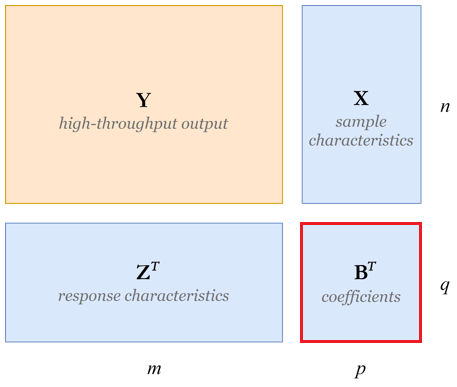

In [12]:
load("../../images/matrixlinearmodel.png")

The model can also be viewed as a bilinear model of $y$ in terms of the $x$ and $z$ covariates:

$$y_{ij} = \sum_{i{=}1}^n \sum_{j{=}1}^m b_{kl} x_{ik} z_{jl} + e_{ij}.$$

The regression coefficients ($b$'s) can be interpreted as interactions between the corresponding $x$ and $z$ covariates.


## Data analysis

### Plotting Attributes

In [13]:
myfont = "Helvetica"
mytitlefontsize = 12; 

### X matrix

In [14]:
names(dfInd)

5-element Vector{String}:
 "Sample"
 "Batch"
 "Group"
 "Statin"
 "FishOil"

In [70]:
contrasts_sams = Dict(
            :Group => EffectsCoding(base = sort(unique(dfInd.Group))[1]),
            :FishOil => EffectsCoding(base = sort(unique(dfInd.FishOil))[1]),
)

frml_sams = "1 +  FishOil +Group"
formulaX = eval(Meta.parse(string("@formula(0 ~ ", frml_sams, ").rhs")))


if occursin("+", frml_sams) || occursin("*", frml_sams)
    vCovarNames = collect(string.(formulaX))
else
    vCovarNames = [string(formulaX)]
end

if ["1"] ⊆ vCovarNames
    vCovarNames[findall(vCovarNames .== "1")] .= "Intercept"
end

idx2change = findall(occursin.("&",vCovarNames))
vCovarNames[idx2change]  .= replace.(vCovarNames[idx2change], " & " => "Ξ")

mX = modelmatrix(formulaX, dfInd, hints = contrasts_sams);
X = mX

vFrmlNames = Vector{String}()

if frml_sams == "1" #frml_c[] == "1"
    # vFrmlNames = ["(Intercept)"]
    vPseudoFrmlNames = ["(Intercept)"]
else
    sch_copd = schema(formulaX, dfInd, contrasts_sams)
    vFrmlNames = apply_schema(formulaX, sch_copd) |> coefnames
end

function fix_covar_name(s::String)
    s = replace(s, "("=>"", ")"=>"", ": "=>"_")
    s = replace(s, " & " => "Ξ")
end

vPseudoFrmlNames = fix_covar_name.(vFrmlNames)

show(vFrmlNames)



["(Intercept)", "FishOil: yes", "Group: CS"]

In [71]:
vCovarNames

3-element Vector{String}:
 "Intercept"
 "FishOil"
 "Group"

### Y matrix

Subset triglycerides:

In [72]:
# Get Zmat for triglycerides
rdZ = "Triglycerides"
fZrawTG = "../../data/data_processed/ZmatRawTG.csv"
dfZraw =  DataFrame(CSV.File(fZrawTG));
# need to filter lipids in dfZrawTG because it was created before imputation
lip_ID_TG = intersect(names(dfMeta), dfZraw.lipID);
filter!(:lipID => x -> x in lip_ID_TG, dfZraw)

m =  length(dfZraw.lipID);

In [73]:
dfY = select(dfMeta, dfZraw.lipID);
mY = Matrix(dfY);
Y = mY;

### Matrix Linear Model with Z=I 

In [74]:
# Select X design model
# if is4ways is true, covariates are
# CN - No Fish Oil, CN - Fish Oil, CS - No Fish Oil, CS - Fish Oil (CN: Control, CS: Statin Intolerant)
#if is4ways is false, covariates are
# Intercept, Group, Fish Oil, Interaction
is4ways = false;

# ZI is identity matrix 
ZI = convert(Array{Float64, }, collect(I(m)));
CoefZI, CIZI, TstatZI, varZI = getCoefs(mY, mX,ZI);

# CoefZI, CIZI, TstatZI, varZI = getCoefs(df, ZI, responseSelection = dfZraw.lipID,
#                                  isunpaired = isunpairFlag, 
#                                  hasFishOil = hasFishOil, 
#                                  is4ways = is4ways);

# Get X and Y 

# if hasFishOil
#     if is4ways
#         X, Y = getXY4ways(df, responseSelection = dfZraw.lipID,
#                  isunpaired = isunpairFlag);
#         covarSelection = ["1"=> "CN-No Fish Oil (intercept)", "2"=> "CN-Fish Oil",
#                       "3"=> "CS-No Fish Oil", "4"=> "CS-Fish Oil"]
#     else
#         X, Y = getXY(df, responseSelection = dfZraw.lipID,
#                  isunpaired = isunpairFlag);
        covarSelection = ["1"=> "Intercept", "2"=> "SAMS status",
                      "3"=> "Fish Oil", "4"=> "Interaction SAMS-Fish Oil"]
#     end
# else
#     X, Y = getXYnoFishOil(df, responseSelection = dfZraw.lipID,
#                  isunpaired = isunpairFlag);
#     covarSelection = ["1"=> "Intercept", "2"=> "SAMS status"]
# end

# # nameX contains labels for plotting
# if  isunpairFlag
#     if is4ways
#         namesX = ["CN-No Fish Oil" "CN-Fish Oil" "CS-No Fish Oil" "CS-Fish Oil"]
#     else
#         namesX = ["Intercept" "SAMS status" "Fish Oil" "Interaction SAMS-Fish Oil"]
#     end
# else
#     namesX = ["Intercept" "Interaction SAMS-Fish Oil"]
# end;

namesX = vCovarNames

3-element Vector{String}:
 "Intercept"
 "FishOil"
 "Group"

### X matrix (individual characteristics)

We assigned a Group-value of 1 to patients in the CS group and -1 to those in the CN group. Similarly, we use a FishOil-value of 1 to indicate that a patient is taking a fish oil supplement, and -1 to indicate that they are not taking one.

In [75]:
DataFrame(X, vCovarNames) |> (x->first(x, 3))

Row,Intercept,FishOil,Group
,Float64,Float64,Float64
1,1.0,1.0,-1.0
2,1.0,1.0,-1.0
3,1.0,1.0,-1.0


### Y matrix (outcome matrix, lipid concentrations)

In [76]:
dfY = DataFrame(Y, dfZraw.lipID) 
first(dfY, 7)

Row,posLip71,posLip132,posLip209,posLip210,posLip211,posLip212,posLip213,posLip214,posLip215,posLip216,posLip217,posLip218,posLip219,posLip220,posLip221,posLip222,posLip223,posLip224,posLip225,posLip226,posLip227,posLip228,posLip229,posLip230,posLip231,posLip232,posLip233,posLip234,posLip235,posLip236,posLip237,posLip238,posLip239,posLip240,posLip241,posLip242,posLip243,posLip244,posLip245,posLip246,posLip247,posLip248,posLip249,posLip250,posLip251,posLip252,posLip253,posLip254,posLip255,posLip256,posLip257,posLip258,posLip259,posLip260,posLip261,posLip262,posLip263,posLip264,posLip265,posLip266,posLip267,posLip268,posLip269,posLip270,posLip271,posLip272,posLip273,posLip274,posLip275,posLip276,posLip277,posLip278,posLip279,posLip280,posLip281,posLip282,posLip283,posLip284,posLip285,posLip286,posLip287,posLip288,posLip289,posLip290,posLip291,posLip292,posLip293,posLip294,posLip295,posLip296,posLip297,posLip298,posLip299,posLip300,posLip301,posLip302,posLip303,posLip304,posLip305,posLip306,⋯
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,0.00478898,-0.740291,0.449654,0.595045,0.378125,0.41719,0.480505,0.243655,0.346091,0.66463,0.759109,0.640774,0.438417,-0.0983832,0.220489,0.377147,0.601962,0.820377,0.340205,0.59773,0.747036,0.887821,0.711585,0.404135,0.648357,0.711382,0.560105,1.12544,0.790067,0.454765,-0.0077685,0.290316,0.375677,0.446744,0.351303,0.532047,0.706379,0.985818,0.682301,0.610145,0.18258,1.04942,0.673875,0.17207,1.05959,1.25577,0.938901,0.259983,0.257034,-0.652505,1.11604,0.73536,0.881136,0.125981,0.518315,1.4043,1.24328,0.592448,0.364434,-0.0980439,-0.321978,-0.0597757,0.574362,0.30493,1.24788,-2.15879,0.559349,0.261874,1.2589,0.554448,1.08725,0.462549,-0.0369073,-0.134995,0.0264202,-0.062307,0.250775,-0.241108,-0.11146,0.170587,-0.426696,0.280718,0.618106,0.310433,0.369277,0.401544,0.406988,-0.48866,-1.25215,-0.728485,-0.32393,-0.574972,-0.0594154,-0.0104656,-0.26047,-0.745899,-0.670105,-1.3719,-0.496476,-0.663698,⋯
2,2.05968,0.192902,0.559006,1.02203,1.05373,0.917115,0.778718,1.35392,0.393166,1.20393,1.78517,0.475491,0.473983,1.35237,1.58076,0.122408,0.545179,0.923952,0.276474,0.443435,0.0878179,-0.0695614,0.313527,1.19205,1.14952,0.612045,1.18653,1.58757,1.92095,0.639936,0.809366,0.6358,1.64821,1.49677,1.05672,1.73785,1.27222,1.0972,1.29418,1.41762,0.0772826,1.30161,0.804348,0.246306,0.437797,0.891462,1.47122,-0.418164,0.036797,-1.69263,0.769311,0.998799,1.16794,1.00379,0.705393,1.4997,1.84132,1.48289,1.31651,1.78151,-0.607887,-0.16307,2.28738,1.27827,2.06042,-0.406113,0.905295,1.94408,1.07412,0.257821,0.935682,0.693413,1.91222,1.60988,1.98365,0.920595,0.268647,0.918536,1.31059,1.81011,1.09753,-0.808484,1.14157,1.13016,0.332114,-1.39453,0.624641,-0.761078,0.628526,1.97696,1.76715,1.29348,1.78448,2.25551,0.904678,2.69464,1.55216,-0.135125,0.527976,0.15238,⋯
3,2.10711,-0.91697,0.168615,0.610545,0.920897,0.678634,0.511035,-0.50629,-0.100823,-0.17059,0.405387,0.0550599,0.145434,0.0415704,0.255393,0.133027,0.434486,-0.410604,-0.395637,1.04012,-0.373829,0.149955,0.593611,0.837442,1.38328,0.468064,1.00474,0.0457446,0.651393,0.234119,-0.577946,0.201969,-0.00167667,-0.00803563,-0.160311,0.568854,0.851927,0.485055,0.442722,0.517852,-1.7139,0.622337,-0.0330319,-1.98015,-0.726071

### Z matrix (lipid characteristics)

Triglycerides'usefull information to build our Z matrix:


In [77]:
dfZraw[1:3,Not(2)]

Row,lipID,Lipids,Oxidation,Plasmalogen,Total_C,Total_DB,Class
,String15,String31,String3,String15,Int64,Int64,String3
1,posLip71,TG(16:0/18:1/18:3(OH)),yes,no,52,4,TG
2,posLip132,TG(O-16:0/16:0/18:1),no,plasmanyl,50,1,TG
3,posLip209,TG(10:0/16:0/18:2),no,no,44,2,TG


### Lipid characteristic distributions

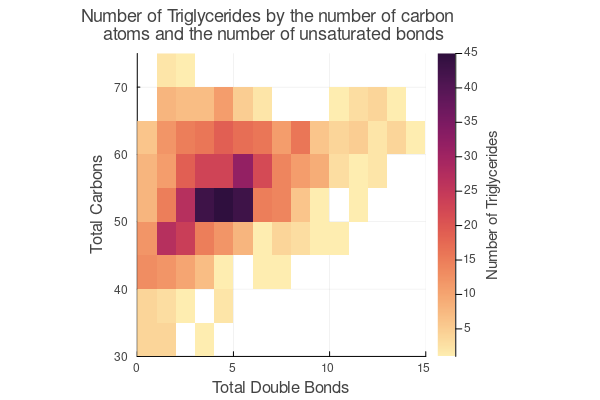

In [78]:
histogram2d(dfZraw.Total_DB, dfZraw.Total_C,
            c= :matter, aspectratio = 0.35, xlim = [0,15],
            colorbar_title = "Number of Triglycerides",
            xlabel= "Total Double Bonds", ylabel =  "Total Carbons",
            title = string("Number of ", rdZ, " by the number of carbon \n atoms and the number of unsaturated bonds \n"),
            fontfamily = myfont,
            titlefontsize = mytitlefontsize,
)

#### Scatterplots of lipid effects analyzed individually

In [79]:
# covarSelection
vCovarNames

3-element Vector{String}:
 "Intercept"
 "FishOil"
 "Group"

In [80]:
# slct1 = covarSelection[3][1];
idxColXmat = 2 #parse(Int64,slct1);

2

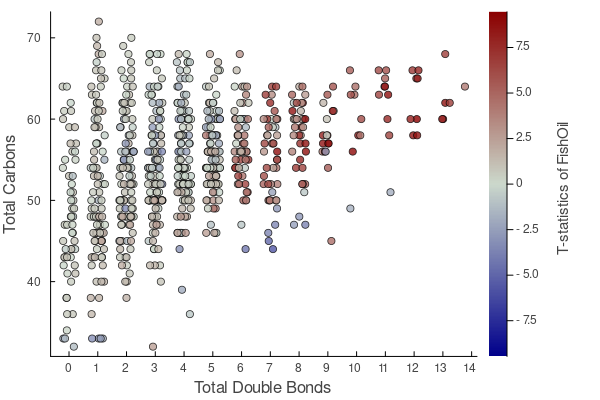

In [81]:
a = 0.25
zlim2 = maximum(abs.(TstatZI[idxColXmat,:]))
p_scatter = scatter(
    dfZraw.Total_DB .+ rand(Uniform(-a,a),length(dfZraw.Total_DB)),
    dfZraw.Total_C,
    zcolor = TstatZI[idxColXmat,:], colorbar = true, m = (:bluesreds, 0.8), 
    colorbar_title = string("\nT-statistics of ",namesX[idxColXmat]),
    xticks=0:1:14, clims = (-zlim2, zlim2), 
    xlabel= "Total Double Bonds", ylabel =  "Total Carbons",
    legend = false, grid = false, tickfontsize=8, 
    fontfamily = myfont,
    right_margin = 10mm,  format = :svg,
    # title = string("T-statistics at the individual level \n for the ", namesX[idxColXmat]),
    titlefontsize = mytitlefontsize,
)

## Modeling decisions

We modeled the MLM according to the length of Carbon chain and the degree of unstaturation of the Triglycerides.

### Total Carbon 

Build the Z matrix based on carbon chain length:

In [82]:
dfRefTG = copy(dfZraw)

vbrks_c = [0,40,45,50,55, 60, 65, 70]
lvls_c = vcat(
    string.(vbrks_c[1:end-1]).*" ≤ Total Carbon < ".*string.(vbrks_c[2:end]),
    "Total Carbon ≥ ".*string.(vbrks_c[end]));
vcatc = cut(
            dfRefTG.Total_C, vbrks_c; 
            labels = lvls_c, 
            extend = true
)

dfRefTG.Total_C_cat = vcatc
namesZtc =lvls_c;
# levelsC = lvls_c


In [83]:
lvls_c

8-element Vector{String}:
 "0 ≤ Total Carbon < 40"
 "40 ≤ Total Carbon < 45"
 "45 ≤ Total Carbon < 50"
 "50 ≤ Total Carbon < 55"
 "55 ≤ Total Carbon < 60"
 "60 ≤ Total Carbon < 65"
 "65 ≤ Total Carbon < 70"
 "Total Carbon ≥ 70"

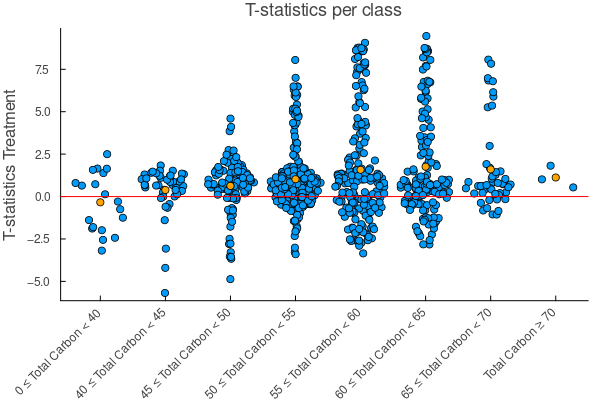

In [85]:
# Create a DataFrame from tStats_diff and append column names from df_baseline
dfTstatsZI = DataFrame(
    hcat(permutedims(TstatZI), names(dfY)[1:end]),
    vcat(["Intercept", "FishOil", "Group"], ["lipID"])
);

# Join dfTstatsZI with dfRef to add SuperClassID and SubClassID using CHEM_ID1 as the key
dfTstatsZI = leftjoin(
    dfTstatsZI, 
    dfRefTG[:, [:lipID, :Total_C_cat]], on = :lipID
    # dfRefTG[:, [:lipID, :Total_C_cat , :Total_DB_cat]], on = :lipID
)

# Generate names for covariate figures based on indices
nameCovarFig = "FishOil"

# Group data by SuperClassID
gdf = groupby(dfTstatsZI, :Total_C_cat);

# Calculate the mean T-statistics for each super class and create a new DataFrame
dfMeanTst = DataFrames.combine(gdf, Symbol(nameCovarFig) => mean => Symbol(nameCovarFig)) 
# Sort the DataFrame by SuperClassID
sort!(dfMeanTst, :Total_C_cat);

# Create a dot plot of T-statistics by super class
p_dot = eval(Meta.parse("@df dfTstatsZI dotplot(string.(:Total_C_cat), :$(nameCovarFig), legend = false, markersize = 4)"))
# Overlay a scatter plot on the dot plot with mean values
eval(Meta.parse("@df dfMeanTst scatter!(string.(:Total_C_cat), :$(nameCovarFig), legend = false, color = :orange)"))
# Add a horizontal line at T=0 for reference
hline!([0], color= :red, 
    label = "",
    xlabel = "Total C category", xrotation = 45,
    ylabel = string("T-statistics ", "Treatment"),
    title = "T-statistics per class",
    titlefontsize = mytitlefontsize,
    fontfamily = myfont, grid = false,
)

# Display the plot
plot(p_dot)

Apply MLM processing:

In [86]:
# Design matrix Z
mZtc_cat = MatrixLM.design_matrix(
	@mlmformula(1 + Total_C_cat),
	dfRefTG,
	 # Dict(:Total_C_cat => StatsModels.FullDummyCoding())
    Dict(:Total_C_cat => StatsModels.DummyCoding(;
            base = lvls_c[1],
            levels = lvls_c
        )
    )
)


# Generate Z matrix
# mZtc_cat = modelmatrix(@formula(y ~ 0 + Total_C_cat).rhs, 
#                     dfRefTG, 
#                     hints = Dict(
#                             :Total_C_cat => StatsModels.FullDummyCoding()));
# mZtc_cat |> x -> hcat(Matrix(dfRefTG[:, [:Total_C_cat]]), x) 

CoefZtc, CIZtc, TstatZtc, varZtc = getCoefs(
    mY, mX,mZtc_cat; 
    hasXIntercept = true, hasZIntercept = true
);

Plot results:

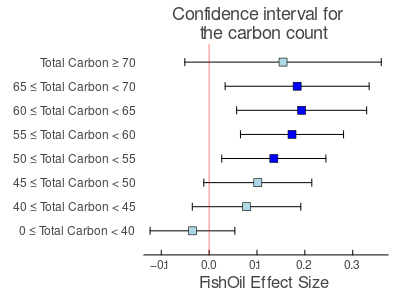

In [87]:
idx = 1
idxColXmatCI = idxColXmat;
p_tc_ci = confidenceplot(
        CoefZtc[idxColXmatCI, idx:end],
        namesZtc[idx:end],
        CIZtc[idxColXmatCI,idx:end],
        xlabel = namesX[idxColXmatCI]*" Effect Size", legend = false,
        fontfamily = myfont,
        title = string("Confidence interval for \n the ", "carbon count") , 
        titlefontsize = mytitlefontsize,
        size=(400,300),  
)

### Double Bonds 

In [88]:
dfZdbcat = DataFrame(intercept = ones(Float64, size(dfZraw)[1]),
        TotalDB_3_6 = ((dfZraw.Total_DB .>= 3) .& (dfZraw.Total_DB .< 6))*1,
        TotalDB_6_9 = ((dfZraw.Total_DB .>= 6) .& (dfZraw.Total_DB .< 9))*1,
        TotalDB_9 = (dfZraw.Total_DB .>= 9)*1	);

In [89]:
vbrks_db = [0,3,6,9];
lvls_db = vcat(
    string.(vbrks_db[1:end-1]).*" ≤ Double Bonds < ".*string.(vbrks_db[2:end]),
    "Double Bonds  ≥ ".*string.(vbrks_db[end]));
    # string.(vbrks_db[end]).*" ≤ Double Bonds");
vcatdb = cut(
            dfRefTG.Total_DB, vbrks_db; 
            labels = lvls_db, 
            extend = true)

dfRefTG.Total_DB_cat = vcatdb

namesZdb = lvls_db;



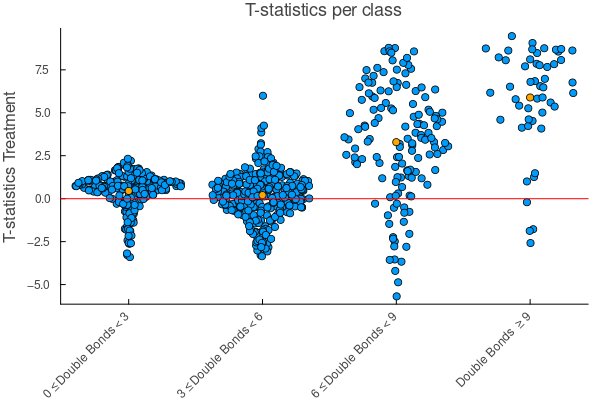

In [90]:
# Create a DataFrame from tStats_diff and append column names from df_baseline
dfTstatsZI = DataFrame(
    hcat(permutedims(TstatZI), names(dfY)[1:end]),
    vcat(["Intercept", "FishOil", "Group"], ["lipID"])
);

# Join dfTstatsZI with dfRef to add SuperClassID and SubClassID using CHEM_ID1 as the key
dfTstatsZI = leftjoin(
    dfTstatsZI, 
    dfRefTG[:, [:lipID, :Total_DB_cat]], on = :lipID
    # dfRefTG[:, [:lipID, :Total_C_cat , :Total_DB_cat]], on = :lipID
)

# Generate names for covariate figures based on indices
nameCovarFig = "FishOil"

# Group data by SuperClassID
gdf = groupby(dfTstatsZI, :Total_DB_cat);

# Calculate the mean T-statistics for each super class and create a new DataFrame
dfMeanTst = DataFrames.combine(gdf, Symbol(nameCovarFig) => mean => Symbol(nameCovarFig)) 
# Sort the DataFrame by SuperClassID
sort!(dfMeanTst, :Total_DB_cat);

# Create a dot plot of T-statistics by super class
p_dot = eval(Meta.parse("@df dfTstatsZI dotplot(string.(:Total_DB_cat), :$(nameCovarFig), legend = false, markersize = 4)"))
# Overlay a scatter plot on the dot plot with mean values
eval(Meta.parse("@df dfMeanTst scatter!(string.(:Total_DB_cat), :$(nameCovarFig), legend = false, color = :orange)"))
# Add a horizontal line at T=0 for reference
hline!([0], color= :red, 
    label = "",
    xlabel = "Total DB category", xrotation = 45,
    ylabel = string("T-statistics ", "Treatment"),
    title = "T-statistics per class",
    titlefontsize = mytitlefontsize,
    fontfamily = myfont, grid = false,
)

# Display the plot
plot(p_dot)

In [91]:
# Design matrix Z
mZdb_cat = MatrixLM.design_matrix(
	@mlmformula(1 + Total_DB_cat),
	dfRefTG,
	 # Dict(:Total_C_cat => StatsModels.FullDummyCoding())
    Dict(:Total_DB_cat => StatsModels.DummyCoding(;
            base = lvls_db[1],
            levels = lvls_db
        )
    )
)

# mZdb_cat = modelmatrix(@formula(y ~ 0 + Total_DB_cat).rhs, 
#                     dfRefTG, 
#                     hints = Dict(:Total_DB_cat => StatsModels.FullDummyCoding()));

CoefZdb, CIZdb, TstatZdb, varZdb  = getCoefs(
    mY, mX,mZdb_cat; 
    hasXIntercept = true, hasZIntercept = true
);

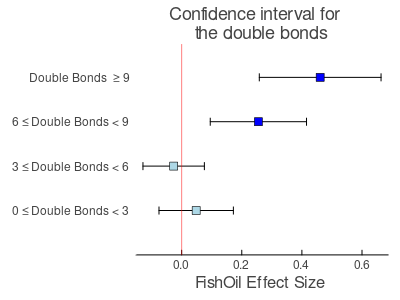

In [92]:
idx = 1
idxColXmatCI = idxColXmat;
p_db_ci = confidenceplot(
        CoefZdb[idxColXmatCI, idx:end],
        namesZdb[idx:end],
        CIZdb[idxColXmatCI,idx:end],
        xlabel = namesX[idxColXmatCI]*" Effect Size", legend = false,
        fontfamily = myfont,
        title = string("Confidence interval for \n the ", "double bonds") , 
        titlefontsize = mytitlefontsize,
        size=(400,300), 
)

### Adjusted 

In [93]:
# Design matrix Z

levelsCdb_cat = vcat(
    ["Intercept"], 
    lvls_c[2:end],
    lvls_db[2:end]
)

mZcdb_cat = MatrixLM.design_matrix(
	@mlmformula(1 + Total_C_cat + Total_DB_cat),
	dfRefTG,
    Dict(
       :Total_DB_cat => StatsModels.DummyCoding(;
            base = lvls_db[1],
            levels = lvls_db
        ),
        :Total_C_cat => StatsModels.DummyCoding(;
            base = lvls_c[1],
            levels = lvls_c
        )
    )
) 

# mZcdb_cat = modelmatrix(
#     @formula(y ~ 1 + Total_C_cat + Total_DB_cat).rhs, 
#     dfRefTG, 
#     hints = Dict(
#         :Total_C_cat => StatsModels.DummyCoding(;
#             base = lvls_c[1],
#             levels = lvls_c
#             ),
#         :Total_DB_cat => StatsModels.DummyCoding(;
#             base = lvls_db[1],
#             levels = lvls_db
#             )
#         )
# );


CoefZcdbcat, CIZcdbcat, TstatZcdbcat, varZcdbcat = getCoefs(
    mY, mX, mZcdb_cat;
    hasXIntercept = true, hasZIntercept = true
);

In [94]:
# Join unadjusted results
namesZtcdb = vcat(namesZtc[2:end], namesZdb[2:end])
CoefZtcdb  = hcat(CoefZtc[:, 2:end] , CoefZdb[:, 2:end])
CIZtcdb    = hcat(CIZtc[:, 2:end] , CIZdb[:, 2:end])
TstatZtcdb = hcat(TstatZtc[:, 2:end] , TstatZdb[:, 2:end])
varZtcdb   = hcat(varZtc[:, 2:end] , varZdb[:, 2:end]);

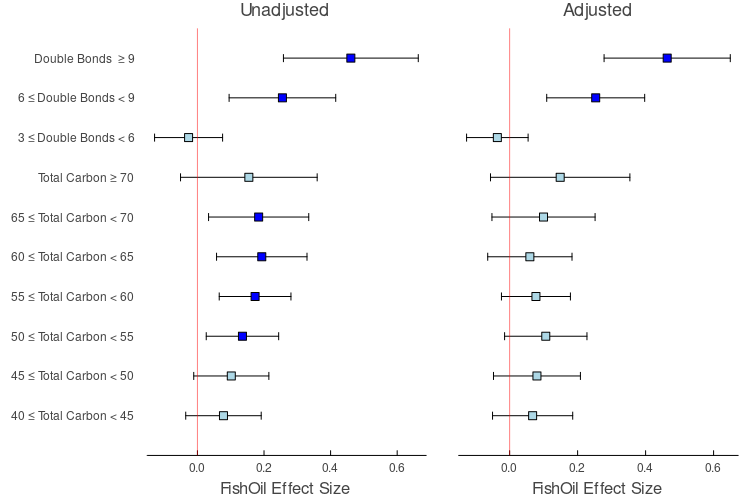

In [95]:
idx = 1
idxColXmatCI = idxColXmat;
p_ci_unadjusted = confidenceplot(
                    CoefZtcdb[idxColXmatCI, :],	
                    namesZtcdb,
                    CIZtcdb[idxColXmatCI, :],
                    xlabel = namesX[idxColXmatCI]*" Effect Size", legend = false,
                    fontfamily = myfont,
                    title = string("Unadjusted") , 
                    titlefontsize = mytitlefontsize,
                    yaxis = true, 
                    right_margin = -10mm, 
                    size=(400,300),  
            )
ptg_cdbcat_adjusted = confidenceplot(
                        vec(permutedims(CoefZcdbcat[idxColXmatCI, 2:end])), 
                        levelsCdb_cat[2:end],
                        vec(permutedims(CIZcdbcat[idxColXmatCI, 2:end])),
                        xlabel = namesX[idxColXmatCI]*" Effect Size", 
                        # xlim = (-0.25,0.25),
                        title = string("Adjusted") , 
                        legend = false,
                        fontfamily = myfont,
                        titlefontsize = mytitlefontsize,
                        yaxis = false, 
                        left_margin = -20mm,
)

p_ua = plot(p_ci_unadjusted, ptg_cdbcat_adjusted, size = (750, 500)) 

savefig("../../images/statin_mlmCI_unadjusted_Fish_Oil_carbon_count_and_degree_of_unsaturation_fomodel.svg")

p_ua

## Enrichment Analysis

### Over Representation Analysis

#### Compute P-values for each triglycerides

In [96]:
TstatZI

3×770 Matrix{Float64}:
  0.144722  -0.456327  0.369272  0.304939  …   2.54414    2.10381   0.514936
  0.567888  -1.44339   0.618201  0.490945      7.82751    6.79422   1.81589
 -0.432202   0.193342  1.69531   1.46582      -0.337807  -1.36198  -0.848368

In [97]:
tstat_fishoil = TstatZI[2,:];

In [98]:
sampleN = 98
pval_fishoil = ccdf.(TDist(sampleN-1), abs.(TstatZI[2,:])).*2;

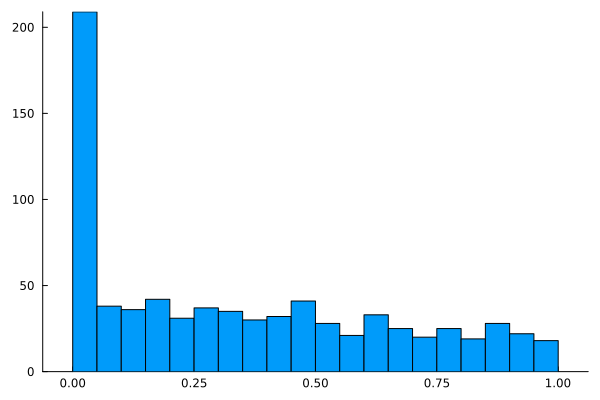

In [99]:
histogram(pval_fishoil, bin= :rice, legend = false, grid = false)

In [100]:
# Hypergeometric(s, f, n)
#Determine
# number of metbolites of interest in a set 
# total of metbolites in a set 
# total of metabolites not in a set
# total number of metabolites of interest

In [101]:
function ora_results(predictor_pval, myZgroups, mysubsets, dfMetabolo, dfAnnotation; thresh = 0.05)

    # Initiate results dataframe
    dfORA = DataFrame(
        Subset = mysubsets, 
        Pval = Vector{Float64}(undef, length(mysubsets))
    );

    # Find index TG with pval less than threshold value , default is 0.05
    idx_sgnf_tg = findall(predictor_pval .< thresh); 
    # Get names of the TGs
    set_sgnf_tg = names(dfMetabolo)[idx_sgnf_tg]

    # Get metbolites population size
    size_metabolites = size(dfMetabolo, 2)
    # Number of success in population
    size_significant = idx_sgnf_tg |> length

    for i in 1:length(mysubsets)
        idx_subset = findall(myZgroups .== mysubsets[i]);
        subset_tg = dfAnnotation.lipID[idx_subset]

        # Sample size
        size_subset = idx_subset |> length
        # Number of successes in sample
        size_significant_subset = intersect(set_sgnf_tg, subset_tg) |> length

        # Hypergeometric distribution
        # mydist = Hypergeometric(
        #             size_subset, 
        #             size_metabolites-size_subset,
        #             size_significant
        #         )
    
        mydist = Hypergeometric(
            size_significant,        
            size_metabolites - size_significant,
            size_subset
            )
        # Calculate p-value
        dfORA.Pval[i] = ccdf(mydist, size_significant_subset)
    end

    return dfORA
end

ora_results (generic function with 1 method)

#### Carbon

In [102]:
dfORA_tc = ora_results(pval_fishoil, dfRefTG.Total_C_cat, lvls_c, dfY, dfRefTG)

Row,Subset,Pval
,String,Float64
1,0 ≤ Total Carbon < 40,0.414591
2,40 ≤ Total Carbon < 45,0.999569
3,45 ≤ Total Carbon < 50,0.946651
4,50 ≤ Total Carbon < 55,0.997946
5,55 ≤ Total Carbon < 60,6.90908e-6
6,60 ≤ Total Carbon < 65,0.00152355
7,65 ≤ Total Carbon < 70,0.822933
8,Total Carbon ≥ 70,0.613825


#### Double Bonds

In [103]:
dfORA_db = ora_results(pval_fishoil, dfRefTG.Total_DB_cat, lvls_db, dfY, dfRefTG)

Row,Subset,Pval
,String,Float64
1,0 ≤ Double Bonds < 3,1.0
2,3 ≤ Double Bonds < 6,1.0
3,6 ≤ Double Bonds < 9,4.26448e-47
4,Double Bonds ≥ 9,4.40938e-22


In [104]:
pval_fishoil_cat_adjusted = ccdf.(TDist(sampleN-1), abs.(TstatZcdbcat[2,:])).*2

11-element Vector{Float64}:
 0.5506506807615892
 0.2636011976960656
 0.22094516192285932
 0.08856911112358049
 0.13808290872453494
 0.3490388429724921
 0.200867287984526
 0.15826830977853512
 0.43568191812846835
 0.0008479729511856924
 3.933640394621486e-6

In [105]:
dfORA_compare = vcat(dfORA_tc[2:end, :], dfORA_db[2:end, :])
dfORA_compare.Pval_MLM_adjusted = pval_fishoil_cat_adjusted[2:end];
dfORA_compare

Row,Subset,Pval,Pval_MLM_adjusted
,String,Float64,Float64
1,40 ≤ Total Carbon < 45,0.999569,0.263601
2,45 ≤ Total Carbon < 50,0.946651,0.220945
3,50 ≤ Total Carbon < 55,0.997946,0.0885691
4,55 ≤ Total Carbon < 60,6.90908e-6,0.138083
5,60 ≤ Total Carbon < 65,0.00152355,0.349039
6,65 ≤ Total Carbon < 70,0.822933,0.200867
7,Total Carbon ≥ 70,0.613825,0.158268
8,3 ≤ Double Bonds < 6,1.0,0.435682
9,6 ≤ Double Bonds < 9,4.26448e-47,0.000847973


In [106]:
pval_fishoil_db_cat_unadjusted = ccdf.(TDist(sampleN-1), abs.(TstatZdb[2,:])).*2;
pval_fishoil_tc_cat_unadjusted = ccdf.(TDist(sampleN-1), abs.(TstatZtc[2,:])).*2;

In [107]:
dfORA_compare.Pval_MLM_unadjusted = vcat(
    pval_fishoil_tc_cat_unadjusted[2:end],
    pval_fishoil_db_cat_unadjusted[2:end]
    )  

10-element Vector{Float64}:
 0.17960360734520592
 0.08042580457879599
 0.016657359315657948
 0.002166717923709742
 0.006376805301087641
 0.018517523553149177
 0.14347925294010272
 0.6111176681542043
 0.002349660595099888
 2.2064485217640932e-5

In [108]:
dfORA_compare

Row,Subset,Pval,Pval_MLM_adjusted,Pval_MLM_unadjusted
,String,Float64,Float64,Float64
1,40 ≤ Total Carbon < 45,0.999569,0.263601,0.179604
2,45 ≤ Total Carbon < 50,0.946651,0.220945,0.0804258
3,50 ≤ Total Carbon < 55,0.997946,0.0885691,0.0166574
4,55 ≤ Total Carbon < 60,6.90908e-6,0.138083,0.00216672
5,60 ≤ Total Carbon < 65,0.00152355,0.349039,0.00637681
6,65 ≤ Total Carbon < 70,0.822933,0.200867,0.0185175
7,Total Carbon ≥ 70,0.613825,0.158268,0.143479
8,3 ≤ Double Bonds < 6,1.0,0.435682,0.611118
9,6 ≤ Double Bonds < 9,4.26448e-47,0.000847973,0.00234966
